YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


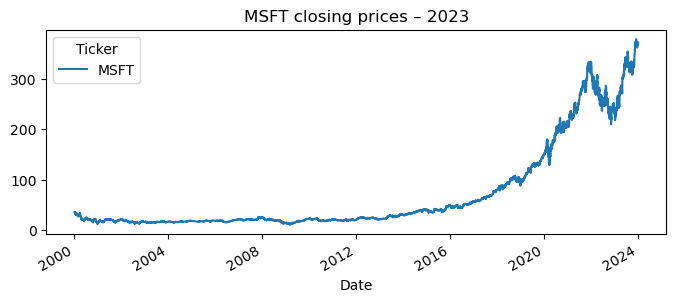

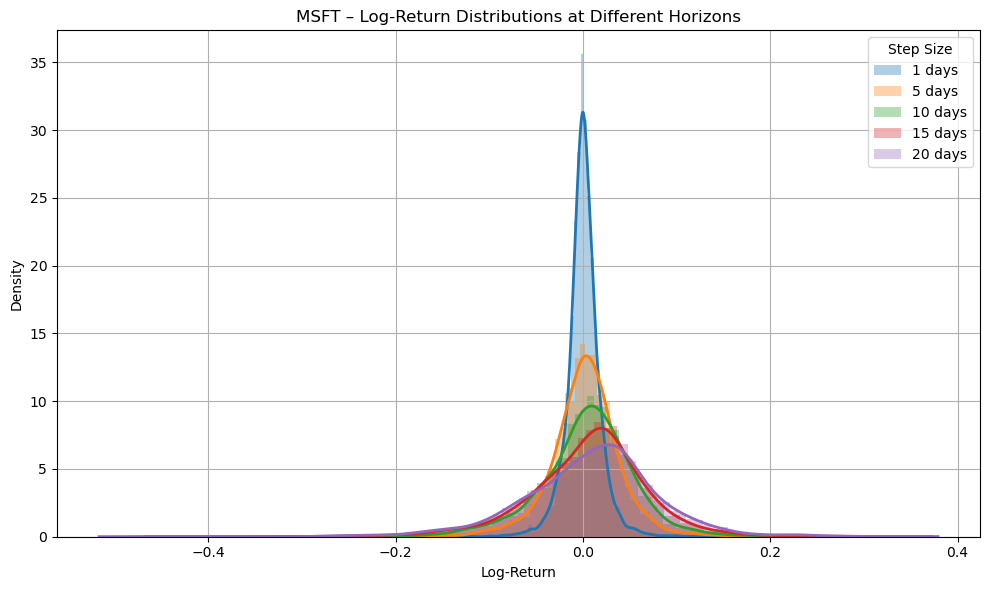

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 7 seconds.


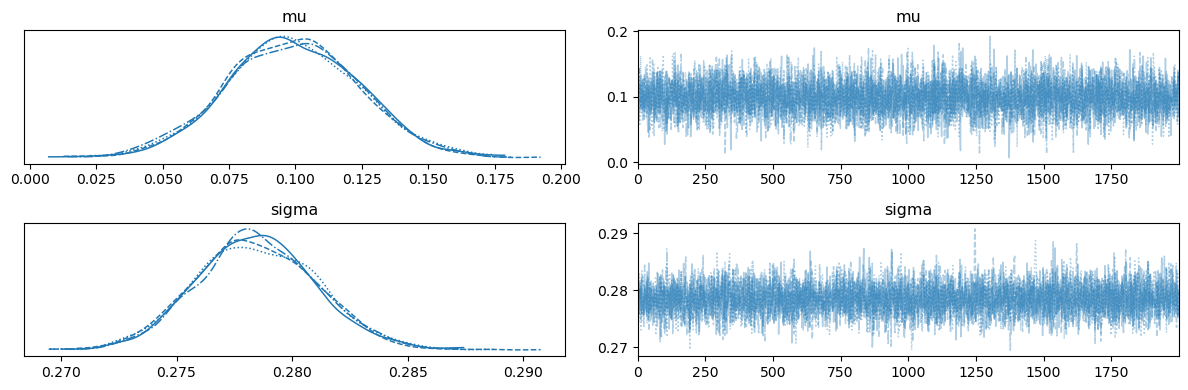

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations

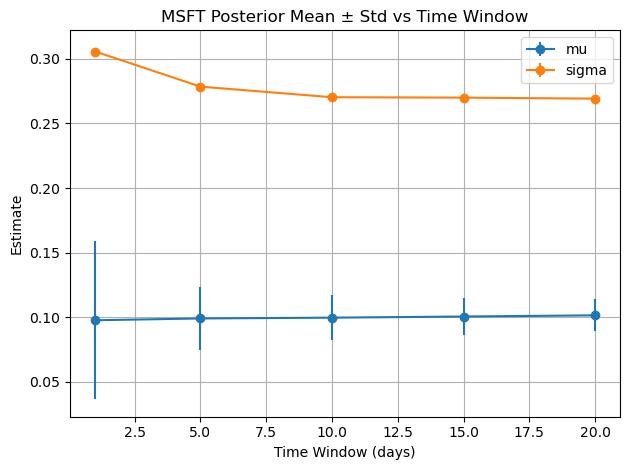

In [1]:
import yfinance as yf
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.stats import gaussian_kde
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az


def plot_prices(prices, time_window_list, stock_name):
    
    prices.plot(title=f"{stock_name} closing prices – 2023", figsize=(8,3))
    plt.show()

    n = len(time_window_list)  # number of colors you need
    colors = plt.cm.tab10.colors[:n]

    plt.figure(figsize=(10, 6))

    for i, step in enumerate(time_window_list):
        log_returns = np.log(prices / prices.shift(step)).dropna().values
        
        plt.hist(
            log_returns,
            bins=100,
            density=True,
            color=colors[i],
            alpha=0.35,
            label=f"{step} days",
            edgecolor='none'
        )
        
        kde = gaussian_kde(log_returns.reshape(1, -1))
        x_vals = np.linspace(log_returns.min(), log_returns.max(), 1000)
        plt.plot(x_vals, kde(x_vals), color=colors[i], linewidth=2)

    plt.title(f"{stock_name} – Log-Return Distributions at Different Horizons")
    plt.xlabel("Log-Return")
    plt.ylabel("Density")
    plt.legend(title="Step Size")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def inference_gbm(prices, time_window, plot =False):
    dt = time_window/252
    biweek_log_returns = np.log(prices / prices.shift(time_window)).dropna().values

    with pm.Model() as gbm_model:
        mu     = pm.Normal("mu", mu=0.0, sigma=10)           # drift  (per year)
        sigma  = pm.HalfNormal("sigma", sigma=10)            # volatility (per √year)

        pm.Normal(
            "returns",
            mu     = mu    * dt,
            sigma  = sigma * np.sqrt(dt),
            observed = biweek_log_returns
        )

        trace = pm.sample(
            draws         = 2000,
            tune          = 2000,
            target_accept = 0.95,
            return_inferencedata=True,
            progressbar   = plot,
        )

    if plot:
        az.plot_trace(trace, var_names=["mu", "sigma"])
        plt.tight_layout(); plt.show()

    summary = az.summary(trace, var_names=["mu", "sigma"], round_to=4)

    mu_mean    = summary.loc["mu", "mean"]
    mu_std     = summary.loc["mu", "sd"]
    sigma_mean = summary.loc["sigma", "mean"]
    sigma_std  = summary.loc["sigma", "sd"]
    
    #print(f"mu = {mu_mean:.4f} ± {mu_std:.4f}")
    #print(f"sigma = {sigma_mean:.4f} ± {sigma_std:.4f}")



    return mu_mean, mu_std, sigma_mean, sigma_std


def inference_gbm_multi_time_scale(prices,time_window_list,stock_name):
    results = []
    for time_window in time_window_list:
        mu_mean, mu_std, sigma_mean, sigma_std = inference_gbm(prices, time_window)
        results.append({
            "time_window": time_window,
            "mu_mean": mu_mean,
            "mu_std": mu_std,
            "sigma_mean": sigma_mean,
            "sigma_std": sigma_std
        })

    results_df = pd.DataFrame(results)

    plt.errorbar(results_df["time_window"], results_df["mu_mean"], yerr=results_df["mu_std"], label="mu", fmt='-o')
    plt.errorbar(results_df["time_window"], results_df["sigma_mean"], yerr=results_df["sigma_std"], label="sigma", fmt='-o')
    plt.xlabel("Time Window (days)")
    plt.ylabel("Estimate")
    plt.legend()
    plt.grid(True)
    plt.title(f"{stock_name} Posterior Mean ± Std vs Time Window")
    plt.tight_layout()
    plt.show()



stock_name = "MSFT"
prices = yf.download(stock_name, start="2000-01-01", end="2023-12-31")["Close"].dropna()
time_window_list = [1, 5, 10, 15, 20]  # trading-day lags

plot_prices(prices, time_window_list, stock_name)
inference_gbm(prices, 5, plot =True)
inference_gbm_multi_time_scale(prices,time_window_list, stock_name)